In [ ]:
#@title Mount Google Drive {display-mode: "form"}

# This code will be hidden when the notebook is loaded.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

import time
from datetime import datetime
import itertools

import pickle

## Traditional ML: Data Importing

In [34]:
# Table showing the breakdown of age-ranges into classes.

combined_classes = pd.read_csv("/content/drive/My Drive/age_classification/input_output/combined_faces_classes_summary.csv")
combined_classes

,Class label,Age-ranges (classes),No. of images,Class balance (%)
0,0,1 - 2,3192,9.53
1,1,3 - 9,2816,8.41
2,2,10 - 20,3136,9.37
3,3,21 - 25,3474,10.37
4,4,26 - 27,3217,9.61
5,5,28 - 31,3063,9.15
6,6,32 - 36,3086,9.22
7,7,37 - 45,3207,9.58
8,8,46 - 54,2802,8.37
9,9,55 - 65,2796,8.35


In [35]:
# Defining a function to return the class labels corresponding to the age-ranges shown above.

def class_labels(age):
    if 1 <= age <= 2:
        return 1
    elif 3 <= age <= 9:
        return 2
    elif 10 <= age <= 20:
        return 3
    elif 21 <= age <= 25:
        return 4
    elif 26 <= age <= 27:
        return 5
    elif 28 <= age <= 31:
        return 6
    elif 32 <= age <= 36:
        return 7
    elif 37 <= age <= 45:
        return 8
    elif 46 <= age <= 54:
        return 9
    elif 55 <= age <= 65:
        return 10
    else:
        return 11

In [36]:
# Importing the feature names.

feature_names = pd.read_csv("/content/drive/My Drive/age_classification/input_output/canny_features_names.csv")
feature_names

,canny_edge_features
0,sec1_mean
1,sec1_std
2,sec2_mean
3,sec2_std
4,sec3_mean
...,...
796,sec399_mean
797,sec399_std
798,sec400_mean
799,sec400_std


In [37]:
# Defining the numpy arrays of train and test datasets.

train = np.load("/content/drive/My Drive/age_classification/input_output/canny_features_age_train.npy")
test = np.load("/content/drive/My Drive/age_classification/input_output/canny_features_age_test.npy")

In [38]:
# Converting the numpy arrays to pandas dataframe.

train_df = pd.DataFrame(train, columns=feature_names["canny_edge_features"])
test_df = pd.DataFrame(test, columns=feature_names["canny_edge_features"])

In [39]:
train_df['age'] = train_df['age'].astype(np.uint8)
test_df['age'] = test_df['age'].astype(np.uint8)

In [40]:
# Creating a column of target class values using the function defined above.

train_df['target'] = train_df['age'].map(class_labels)
test_df['target'] = test_df['age'].map(class_labels)

## Traditional ML: Model Preparation

In [41]:
# Splitting the above train and test dataframes into features (X) and target (y).
X_train = train_df.drop(columns=['age', 'target'])
y_train = train_df['target']

X_test = test_df.drop(columns=['age', 'target'])
y_test = test_df['target']

In [42]:
# Scaling X_train to the standard scale.
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)

In [43]:
# Transforming X_test to the same scale.
X_test_sc = ss.transform(X_test)

## Traditional ML: Classification Modelling

### *GridSearchCV* with *RandomForestClassifier*

In [44]:
# Creating a RandomForestClassifier object.

rfc = RandomForestClassifier(
                             ccp_alpha=0,
                             min_samples_split=2,
                             min_samples_leaf=1,
                             random_state=42
                            )

In [45]:
# Establishing ranges of hyperparameters of RandomForestClassifier for GridSearchCV.

rfc_params = {'n_estimators' : [50, 100, 200],
              'max_depth' : [5, 7, 9],
             }

In [46]:
# Creating a GridSearchCV object for the RandomForestClassifier object defined above.

rfc_gs = GridSearchCV(rfc, param_grid=rfc_params, n_jobs=-1, cv=5)

In [47]:
# Fitting X_train_sc and y_train on GridSearchCV object with RandomForestClassifier defined above.

rfc_gs.fit(X_train_sc, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                    

In [48]:
# Best combination of hyperparameters suggested by GridSearchCV.

rfc_gs.best_params_

{'max_depth': 9, 'n_estimators': 200}

In [49]:
# Best accuracy score obtained by the above combination of hyperparameters.

rfc_gs.best_score_

0.38865187713310584

In [50]:
# Scoring the model on training dataset.
# Training Accuracy

rfc_train_acc = rfc_gs.score(X_train_sc, y_train)
rfc_train_acc

0.6684300341296928

In [51]:
# Actual Testing Accuracy

rfc_test_acc = rfc_gs.score(X_test_sc, y_test)
rfc_test_acc

0.4000597252637866

In [52]:
# Summary scores from GridSearchCV with RandomForestClassifier.

print("RandomForestClassifier summary of accuracy scores:")
print(f"GridSearchCV best accuracy (cv=5) = {round(rfc_gs.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training accuracy = {round(rfc_train_acc, 3)}")
print(f"Testing accuracy = {round(rfc_test_acc, 3)}")

RandomForestClassifier summary of accuracy scores:
GridSearchCV best accuracy (cv=5) = 0.389

Using GridSearchCV best params suggested,
Training accuracy = 0.668
Testing accuracy = 0.4


In [53]:
# Generating predictions on testing dataset using the model above.

rfc_pred = rfc_gs.predict(X_test_sc)

In [54]:
# Generating a confusion matrix based on above predictions.

conf_mat_rfc = confusion_matrix(y_test, rfc_pred)
conf_mat_rfc

array([[848,  27,  12,  38,  11,   0,   2,   9,   5,   2,   4],
       [220, 354,  74,  96,  18,   1,   3,  46,  13,  10,  10],
       [ 59,  56, 405, 220,  49,   4,  10,  85,  18,  10,  25],
       [ 29,  27,  47, 649, 115,  10,  13, 111,  18,   7,  16],
       [ 52,  22,  23, 385, 246,   5,  25, 152,  25,  13,  17],
       [ 22,  30,  32, 348, 128,  47,  30, 183,  46,  24,  29],
       [ 34,  24,  44, 266, 115,   8,  60, 231,  67,  36,  41],
       [ 35,  17,  33, 186, 111,   7,  23, 338, 107,  52,  53],
       [ 20,   8,  35, 106,  55,   3,  14, 194, 265,  59,  81],
       [ 24,   8,  31,  84,  39,   2,   5, 166,  65, 279, 136],
       [ 22,   8,  20,  37,  25,   1,   8,  78,  48,  34, 528]])

In [55]:
# Defining a function to plot the confusion matrix in a grid for easier visualization.

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

    # Exporting plot image in PNG format.
    plt.savefig(f'/content/drive/My Drive/age_classification/plot_images/{export_as}.png', bbox_inches='tight');

Normalized confusion matrix


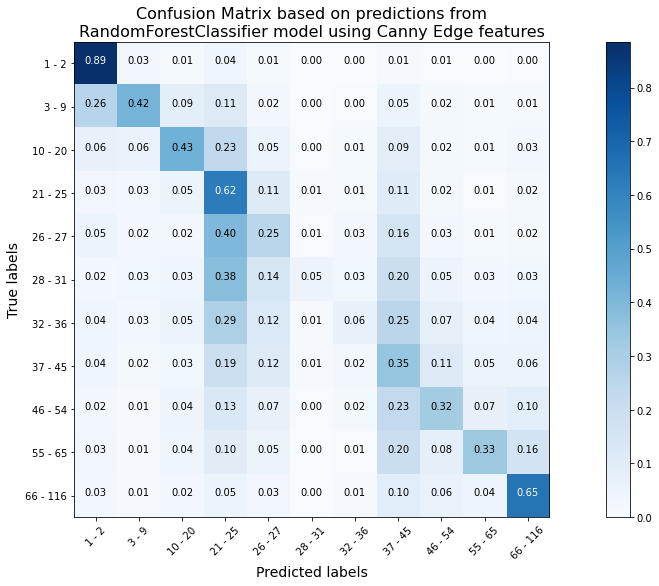

In [56]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = combined_classes['Age-ranges (classes)']

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat_rfc, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from\nRandomForestClassifier model using Canny Edge features",
                      export_as="rfc_canny_conf_mat_norm"
                     )

plt.show()

Confusion matrix, without normalization


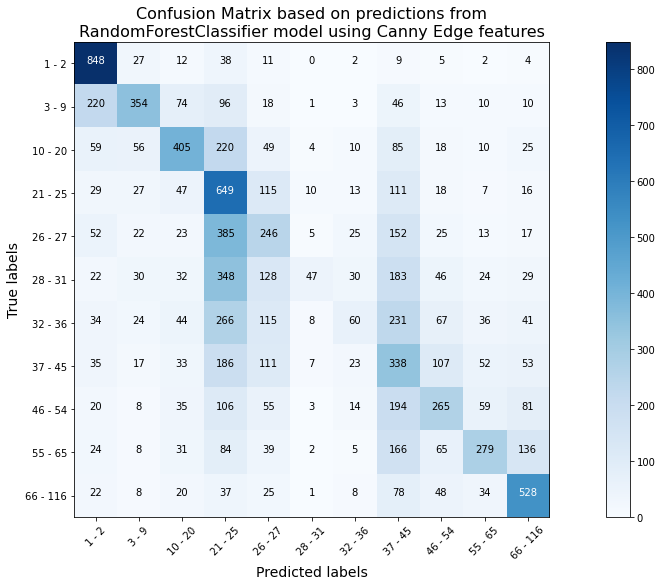

In [57]:
# Plotting the confusion matrix using the function defined above.

cm_plot_labels = combined_classes['Age-ranges (classes)']

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat_rfc, cm_plot_labels, normalize=False,
                      title="Confusion Matrix based on predictions from\nRandomForestClassifier model using Canny Edge features",
                      export_as="rfc_canny_conf_mat"
                     )

plt.show()

In [58]:
# Saving the RandomForestClassifier model from above in a pickle file for possible use later.

rfc_pickle = f"/content/drive/My Drive/age_classification/input_output/rfc_canny_model_acc_{round(rfc_test_acc, 3)}"
pickle.dump(rfc_gs, open(rfc_pickle, 'wb'))

### GridSearchCV with SVC

In [59]:
# Creating a SVC object.
svc = SVC(random_state=42)

In [60]:
# Establishing ranges of hyperparameters of SVC for GridSearchCV.

svc_params = {'C' : [0.001, 1],
              'kernel' : ['rbf', 'poly', 'linear'],
              'degree' : [3, 5]
             }

In [61]:
# Creating a GridSearchCV object for the SVC object defined above.

svc_gs = GridSearchCV(svc, param_grid=svc_params, n_jobs=-1, cv=5)

In [ ]:
# Fitting X_train_sc and y_train on GridSearchCV object with SVC defined above.

svc_gs.fit(X_train_sc, y_train)

In [ ]:
# Best combination of hyperparameters suggested by GridSearchCV.

svc_gs.best_params_

In [ ]:
# Best accuracy score obtained by the above combination of hyperparameters.

svc_gs.best_score_

In [ ]:
# Training Accuracy

svc_train_acc = svc_gs.score(X_train_sc, y_train)
svc_train_acc

0.9286689419795222

In [ ]:
# Actual Testing Accuracy

svc_test_acc = svc_gs.score(X_test_sc, y_test)
svc_test_acc

0.5337447740394187

In [ ]:
print("SVC summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(svc_gs.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training accuracy = {round(svc_train_acc, 3)}")
print(f"Testing accuracy = {round(svc_test_acc, 3)}")

SVC summary of accuracy scores:
GridSearchCV best accuracy = 0.49

Using GridSearchCV best params suggested,
Training accuracy = 0.929
Testing accuracy = 0.534


In [ ]:
# Generating predictions on testing dataset using the model above.

svc_pred = svc_gs.predict(X_test_sc)

In [ ]:
# Generating a confusion matrix based on above predictions.
conf_mat_svc = confusion_matrix(y_test, svc_pred)
conf_mat_svc

array([[881,  19,   1,  10,  12,   3,  19,  12,   0,   0,   1],
       [ 61, 588,  34,  70,  20,   9,  36,  24,   2,   1,   0],
       [  8,  36, 533, 219,  43,  18,  36,  32,   7,   4,   5],
       [  2,   4,  34, 709, 110,  59,  64,  51,   3,   2,   4],
       [  4,   9,  12, 293, 400,  61,  98,  63,   6,  10,   9],
       [  0,   6,  13, 267, 140, 258, 114,  91,  16,   6,   8],
       [  1,   5,   9, 177, 133,  64, 334, 159,  30,   8,   6],
       [  2,   3,  10,  98, 105,  48, 146, 485,  38,  15,  12],
       [  2,   9,  13,  51,  54,  21,  92, 213, 320,  47,  18],
       [  2,   5,  13,  57,  43,  17,  96, 172,  57, 332,  45],
       [  0,   6,  15,  18,  22,  11,  42,  97,  32,  44, 522]])

Normalized confusion matrix


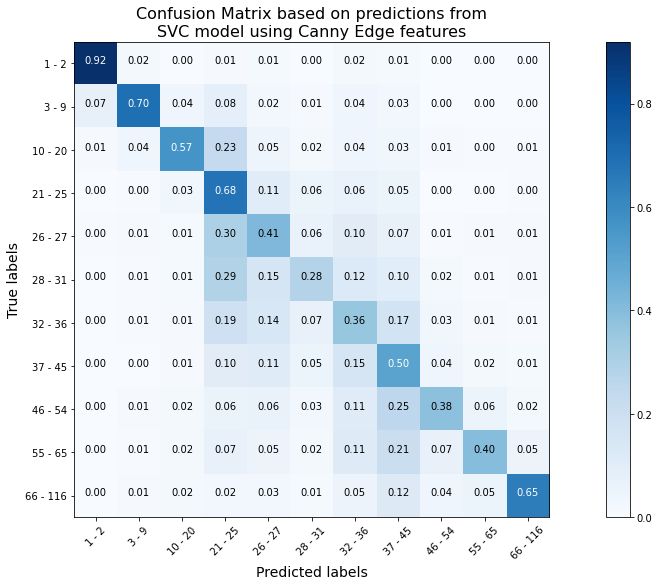

In [ ]:
# Plotting the NORMALIZED confusion matrix using the function defined above.
cm_plot_labels = combined_classes['Age-ranges (classes)']
plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat_svc, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from\nSVC model using Canny Edge features",
                      export_as="svc_canny_conf_mat_norm"
                     )

plt.show()

Confusion matrix, without normalization


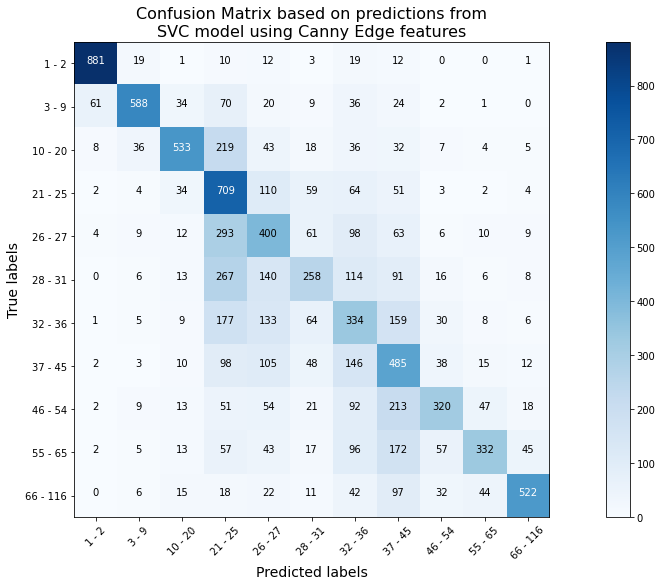

In [ ]:
# Plotting the confusion matrix using the function defined above.
cm_plot_labels = combined_classes['Age-ranges (classes)']
plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat_svc, cm_plot_labels, normalize=False,
                      title="Confusion Matrix based on predictions from\nSVC model using Canny Edge features",
                      export_as="svc_canny_conf_mat"
                     )

plt.show()

In [ ]:
# Saving the SVC model
svc_pickle = f"/content/drive/My Drive/Age_Classification_with_Faces/input_output/svc_canny_model_acc_{round(svc_test_acc, 3)}"
pickle.dump(svc_gs, open(svc_pickle, 'wb'))